# Tutorial 2: Analyzing Statistics and Variogram of the Ice Stream Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
import skgstat as skg
from gstatsMCMC import gstatsim_custom as gsm
from pathlib import Path

/home/niyashao/miniforge3/envs/geostats/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import QuantileTransformer

### First load data

The code is tested by a cropped region for shorter running time

In [3]:
# load compiled bed elevation measurements
df = pd.read_csv('DenmanDataGridded.csv')

In [4]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)
bedmachine_bed = bedmap_surf - bedmachine_thickness

### Now, it is the time to analyze the compiled radar data.

#### Fit variogram

MCMC.fit_variogram is a wrapper around functions in scikit-learn and skgstats python modules. It conveniently normalize the provided bed elevation data, calculate the semi-variogram, and fit it with four different models (Gaussian, Exponential, Spherical, Matern). The output map could be used to visually decide which variogram model fit the data the best.

In [6]:
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

In [7]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

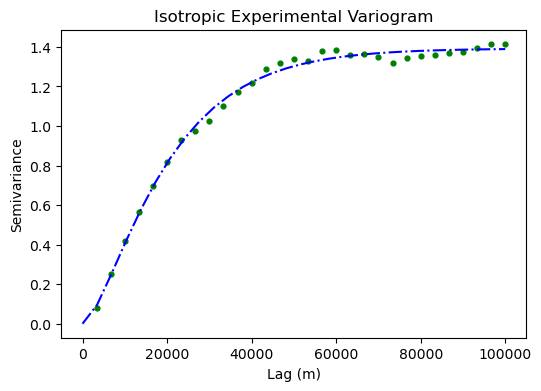

In [8]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 100000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [9]:
V1_p

[53662.73375157593, 1.3922864575463436, 0.9680270080768958, 0]

__Q1: How does the maxlag and n_lags affect variogram calculated? How you determine their values such that your variogram is accurately represented?__

__Q2: Which variogram model you choose? Why?__

#### Generate initial bed

Let's generate a SGS bed for the entire region

https://gatorglaciology.github.io/gstatsimbook/4_Sequential_Gaussian_Simulation.html 

In [10]:
df_bed = df.copy()
df_bed = df_bed[df_bed["cond_bed"].isnull() == False]

data = df_bed['cond_bed'].values.reshape(-1,1)
transformed_data = nst_trans.transform(data)
df_bed['Nbed'] = transformed_data.flatten()

In [ ]:
k = 48
rad = 50e3
variogram = {
    'azimuth' : 0.0,
    'nugget' : 0.0,
    'major_range' : V1_p[0],
    'minor_range' : V1_p[0],
    'sill' : V1_p[1],
    's' : V1_p[2],
    'vtype' : 'matern',
}

lower_bound = np.full(xx.shape,-9999)
upper_bound = np.where(np.isnan(bedmap_surf),np.nanmax(bedmap_surf), bedmap_surf)

sim = gsm.interpolate.sgs(xx, yy, cond_bed, variogram, radius=rad, 
                          num_points=k, bounds=(lower_bound,upper_bound),
                          seed=None)

In [16]:
np.savetxt('sgs_bed_denman.txt',sim)

In [12]:
# simulate for multiple sgs realizations with seeds
seed_file_path = '../200_seeds.txt'

with open(Path(seed_file_path), 'r') as f:
    lines = f.readlines()

rng_seeds = []
for line in lines:
    rng_seeds.append(int(line.strip()))

n_sgs_bed = 10
for i in range(n_sgs_bed):
    sim = gsm.interpolate.sgs(xx, yy, cond_bed, variogram, radius=rad, 
                              num_points=k, bounds=(lower_bound,upper_bound), 
                              seed=rng_seeds[i])
    np.savetxt('Denman_sgs_bed_'+str(i)+'.txt',sim)

100%|██████████████████████████████████| 320000/320000 [16:37<00:00, 320.91it/s]


SGS only generate a realization of the bed topography according to the known radar measurements. However, it might ignored something else. The thickness of the ice can be calculated as ice surface elevation minus bed elevation. From BedMachine, we know where the land is ice-free and where is covered by ice. However, SGS might generate bed such that it 'extrude' out of ice in the supposed grounded ice region. Let's fix that quickly

In [23]:
sgs_bed = np.loadtxt('sgs_bed_denman.txt')

In [24]:
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

There are other things we would like to record before begin the MCMC chains

In [25]:
cond_bed = df['cond_bed'].values.reshape(xx.shape)
data_mask = ~np.isnan(cond_bed)

(2200000.0, 2600000.0, -500500.0, -300500.0)

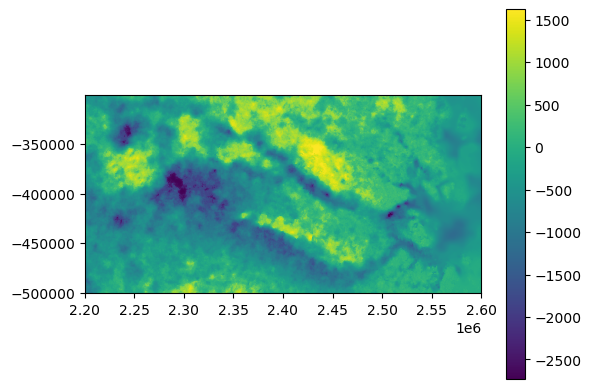

In [26]:
plt.pcolormesh(xx,yy,sgs_bed)
plt.colorbar()
plt.axis('scaled')

(0.0, 800.0, 0.0, 400.0)

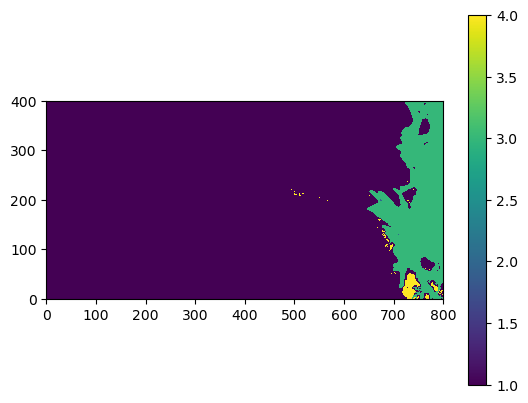

In [27]:
plt.pcolormesh(bedmap_mask)
plt.colorbar()
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

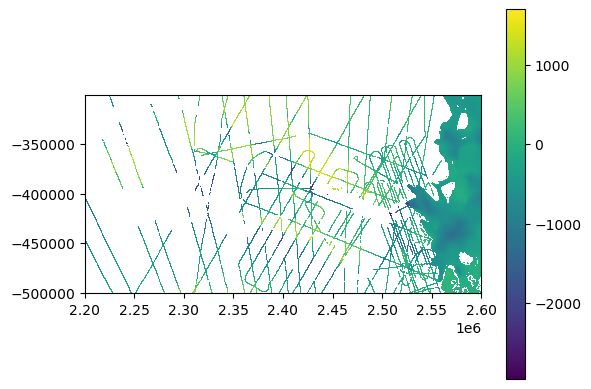

In [28]:
plt.pcolormesh(xx,yy,cond_bed)
plt.colorbar()
plt.axis('scaled')

(0.0, 800.0, 0.0, 400.0)

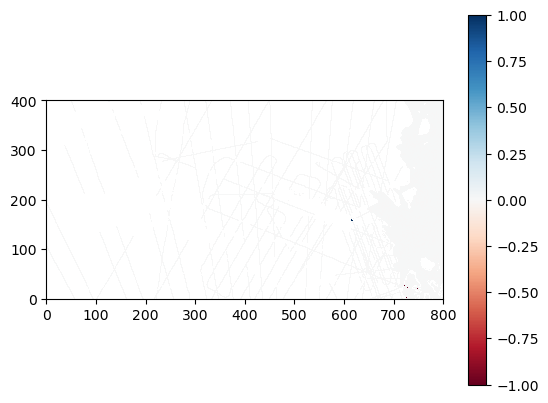

In [29]:
plt.pcolormesh(sgs_bed - cond_bed,vmax=1,vmin=-1,cmap='RdBu')
plt.colorbar()
plt.axis('scaled')